In [1]:
import datetime as dt
import glob
import os
import pickle
import re
import string
import sys
import time
import warnings
from datetime import datetime
from pathlib import Path

import featuretools as ft
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from nltk import word_tokenize
from nltk.corpus import (
    stopwords,
    wordnet,
)
from nltk.stem import (
    PorterStemmer,
    WordNetLemmatizer,
)
from scipy.stats.mstats import winsorize
from sklearn.base import (
    BaseEstimator,
    TransformerMixin,
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    MinMaxScaler,
    StandardScaler,
    normalize,
)
from tqdm import tqdm

nltk.download("wordnet")
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)

[nltk_data] Downloading package wordnet to /home/javier/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
tqdm.pandas()

In [3]:
PACKAGE_ROOT = Path(os.getcwd()).parent.parent
sys.path.append(str(PACKAGE_ROOT.parent))

In [4]:
PACKAGE_ROOT

PosixPath('/home/javier/repos/mle_challenge/model')

In [5]:
DATAPATH = os.path.join(PACKAGE_ROOT, "experiments/data")

In [6]:
DATAPATH

'/home/javier/repos/mle_challenge/model/experiments/data'

In [7]:
raw_train = pd.read_csv(os.path.join(DATAPATH, "train.csv"))
raw_test = pd.read_csv(os.path.join(DATAPATH, "test.csv"))

In [8]:
raw_test[raw_test['description'].isnull()]

,uid,city,description,homeType,latitude,longitude,garageSpaces,hasSpa,yearBuilt,numOfPatioAndPorchFeatures,lotSizeSqFt,avgSchoolRating,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,priceRange
401,13491,austin,NaN,Single Family,30.189535,-97.897896,2,False,2002,1,10890.0,8.666667,18,3.0,4,450000-650000


---

<center><h1>💻💻 Data Preparation 💻 💻</h1></center>

---

In [9]:
raw_train.sample(3)

,uid,city,description,homeType,latitude,longitude,garageSpaces,hasSpa,yearBuilt,numOfPatioAndPorchFeatures,lotSizeSqFt,avgSchoolRating,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,priceRange
7056,8016,austin,"3304 Mcelroy Dr #A, Austin, TX 78757 is a cond...",Condo,30.357960,-97.743401,2,False,1966,2,8712.0,6.666667,16,2.0,3,350000-450000
1382,2197,austin,Vista Point 1792 1-story plan has 4-Sides maso...,Single Family,30.163876,-97.732552,2,False,2015,1,6054.0,3.666667,12,2.0,3,250000-350000
6278,7246,austin,"8300 Belclaire Cir, Austin, TX 78748 is a sing...",Single Family,30.179314,-97.792999,0,False,1977,1,11325.6,3.333333,13,2.0,4,250000-350000


In [10]:
raw_test.dtypes

uid                             int64
city                           object
description                    object
homeType                       object
latitude                      float64
longitude                     float64
garageSpaces                    int64
hasSpa                           bool
yearBuilt                       int64
numOfPatioAndPorchFeatures      int64
lotSizeSqFt                   float64
avgSchoolRating               float64
MedianStudentsPerTeacher        int64
numOfBathrooms                float64
numOfBedrooms                   int64
priceRange                     object
dtype: object

In [29]:
raw_train.shape, raw_test.shape

((9000, 16), (1000, 16))

In [12]:
PACKAGE_ROOT

PosixPath('/home/javier/repos/mle_challenge/model')

In [17]:
import packaging_ml_model.prediction_model.processing.preprocessing as pp
from packaging_ml_model.prediction_model.config import config

In [18]:
pipeline = Pipeline(
    [
        (
            "DataFrameTypeConverter",
            pp.DataFrameTypeConverter(conversion_dict=config.CONVERSION_DICT),
        ),
        (
            "DropColumns",
            pp.DropColumns(variables_to_drop=config.VARIABLES_TO_DROP),
        ),
        (
            "ModeImputer",
            pp.ModeImputer(variables=config.CATEGORICAL_FEATURES),
        ),
        (
            "DataFrameProcessor",
            pp.DataFrameProcessor(features=config.FEATURES_MODIFY, quantile_threshold=0.1),
        ),
        (
            "MedianImputer",
            pp.MedianImputer(variables=config.NUMERICAL_FEATURES),
        ),
        (
            "Winsorizer",
            pp.Winsorizer(numerical_features=config.NUMERICAL_FEATURES, limits=[0.025, 0.025]),
        ),
        (
            "DropColumns2",
            pp.DropColumns(variables_to_drop=config.NUMERICAL_FEATURES),
        ),
        (
            "CoordinateBinner",
            pp.CoordinateBinner(columns=config.GEOLOCATION, decimal_places=3),
        ),
        (
            "DropColumns3",
            pp.DropColumns(variables_to_drop=config.GEOLOCATION),
        ),
        (
            "TextProcessor",
            pp.TextProcessor(column=config.DESCRIPTION_FEATURE, blacklist=config.BLACK_LIST),
        ),
        (
            "TFIDFTransformer",
            pp.TFIDFTransformer(column=config.DESCRIPTION_FEATURE, max_features=20),
        ),
        (
            "NumericalFeatureSelector",
            pp.NumericalFeatureSelector(remove_columns=config.TO_REMOVE),
        ),
        (
            "LogTransforms",
            pp.LogTransforms(),
        ),
        (
            "DataScaler",
            pp.DataScaler(),
        ),
        (
            "CorrelationMatrixProcessor",
            pp.CorrelationMatrixProcessor(threshold=0.7),
        ),
        (
            "FeatureVariance",
            pp.FeatureVariance(threshold=0.001),
        ),
        (
            "DropColumns4",
            pp.DropColumns(variables_to_drop=config.DESCRIPTION_FEATURE),
        ),
        (
            "LabelEncoderProcessor",
            pp.LabelEncoderProcessor(),
        ),
        (
            "DataFrameTypeConverter2",
            pp.DataFrameTypeConverter(conversion_dict=config.CONVERSION_DICT2),
        ),
    ]
)

In [19]:
transformed_train = pipeline.fit_transform(raw_train)

In [20]:
transformed_train.sample()

,city,homeType,hasSpa,priceRange,garageSpaces_winsor,yearBuilt_winsor,numOfPatioAndPorchFeatures_winsor,lotSizeSqFt_winsor,avgSchoolRating_winsor,numOfBathrooms_winsor,numOfBedrooms_winsor,homeType_count_winsor,latitude_winsor_3,longitude_winsor_3,area,back,backyard,build,ceiling,contain,family,feature,from,great,include,large,living,lot,new,open,update,walk
6436,1.0,1.0,0.0,2,0.682606,0.734621,0.5,0.235674,0.710023,0.63093,0.415037,1.0,0.813145,0.258864,0.0,0.392376,0.366115,0.0,0.390182,0.0,0.0,0.0,0.0,0.383926,0.0,0.326928,0.333059,0.661114,0.0,0.326144,0.0,0.387745


In [21]:
raw_train.sample()

,uid,city,description,homeType,latitude,longitude,garageSpaces,hasSpa,yearBuilt,numOfPatioAndPorchFeatures,lotSizeSqFt,avgSchoolRating,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,priceRange
18,9914,austin,Recently remodeled 3 Bedroom 2 Bath house. All...,Single Family,30.291206,-97.677483,1,False,1999,0,7666.0,3.0,15,2.0,3,0-250000


In [22]:
transformed_test = pipeline.fit_transform(raw_test)

In [23]:
transformed_train.shape, transformed_test.shape

((9000, 32), (1000, 32))

In [24]:
transformed_train.isnull().sum().sum(), transformed_test.isnull().sum().sum()

(0, 0)

In [25]:
list_train = list(transformed_train.columns)
list_test = list(transformed_test.columns)

In [26]:
no_common1 = [element for element in list_train if element not in list_test]
no_common2 = [element for element in list_test if element not in list_train]

In [27]:
no_common1, no_common2

([], [])

In [30]:
train_y = transformed_train['priceRange']
train_X = transformed_train.drop(['priceRange'], axis=1)

In [32]:
#Let’s split X and y using Train validation split
X_train, X_validation, y_train, y_validation = train_test_split(train_X, train_y, train_size=0.8, random_state= 2022, stratify=train_y)

#get shape of train and test data
print("train data size:", X_train.shape)
print("test data size:", X_validation.shape)

train data size: (7200, 31)
test data size: (1800, 31)


In [34]:
y_train.value_counts(normalize=True), y_validation.value_counts(normalize=True)

(priceRange
 1    0.235833
 2    0.230694
 3    0.228194
 4    0.181667
 0    0.123611
 Name: proportion, dtype: float64,
 priceRange
 1    0.236111
 2    0.230556
 3    0.228333
 4    0.181667
 0    0.123333
 Name: proportion, dtype: float64)

In [35]:
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.metrics import classification_report, accuracy_score

In [36]:
from sklearn.ensemble import StackingClassifier

In [37]:
from sklearn.model_selection import KFold

In [38]:
import time

In [39]:
def cv_score(ml_model, rstate=11, cols=None, df=None, df_y=None):
    start_time = time.time()

    if df is None or df_y is None:
        raise ValueError("DataFrames df and df_y must be provided")

    if cols is not None:
        df1 = df[cols].copy()
    else:
        df1 = df.copy()

    i = 1
    cv_scores = []
    
    kf = KFold(n_splits=5, random_state=rstate, shuffle=True)
    
    for train_index, test_index in kf.split(df1):
        xtr, xvl = df1.iloc[train_index], df1.iloc[test_index]
        ytr, yvl = df_y.iloc[train_index], df_y.iloc[test_index]

        model = ml_model
        model.fit(xtr, ytr)
        pred_val = model.predict(xvl)
        
        # Calculate accuracy
        accuracy = accuracy_score(yvl, pred_val)
        
        # Save scores
        cv_scores.append(accuracy)
        i += 1
    end_time = time.time()
    
    print(f"The duration for training the model is: {(end_time - start_time)}. The scores are given by {np.mean(cv_scores)}")
    return cv_scores

In [40]:
random_forest_classifier = cv_score(RandomForestClassifier(n_estimators=100, random_state=20230916), df = X_train, df_y = y_train)

The duration for training the model is: 5.460996627807617. The scores are given by 0.5955555555555556


In [41]:
knn_neighbors_classifier = cv_score(KNeighborsClassifier(n_neighbors=3), df = X_train, df_y = y_train)

The duration for training the model is: 0.43598484992980957. The scores are given by 0.3675


In [42]:
decision_tree_classifier = cv_score(DecisionTreeClassifier(random_state=20230916), df = X_train, df_y = y_train)

The duration for training the model is: 0.3497886657714844. The scores are given by 0.49777777777777776


In [43]:
xgb_classifier = cv_score(XGBClassifier(random_state=20230916), df = X_train, df_y = y_train)

The duration for training the model is: 4.647068738937378. The scores are given by 0.5877777777777778


In [44]:
results_df = pd.DataFrame({'RandomForestClassifier':random_forest_classifier, 
                           'KNeighborsClassifier': knn_neighbors_classifier, 
                           'DecisionTreeClassifier': decision_tree_classifier, 
                           'XGBClassifier': xgb_classifier})

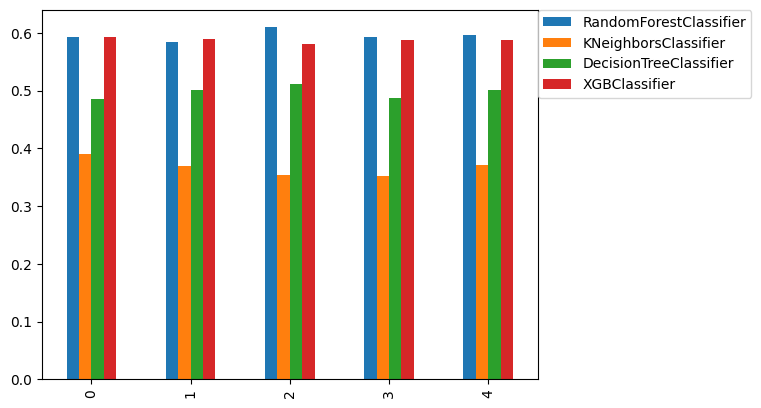

In [45]:
results_df.plot(y=["RandomForestClassifier", "KNeighborsClassifier", 'DecisionTreeClassifier', 'XGBClassifier'], kind="bar", legend=False)
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
plt.show()

In [47]:
# Base models
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=20230916)),
    ('xgb', XGBClassifier(random_state=20230916)),
]

# Meta-model
meta_model = LogisticRegression()

# Stacking classifier
stacking_clf = StackingClassifier(estimators=estimators, 
                                  final_estimator=meta_model,
                                  cv=5)

# Fit the model
stacking_clf.fit(X_train, y_train)

# Make predictions
y_pred = stacking_clf.predict(X_validation)

In [49]:
print("Accuracy:", accuracy_score(y_validation, y_pred))
print("\nClassification Report:\n", classification_report(y_validation, y_pred))

Accuracy: 0.6094444444444445

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.46      0.58       222
           1       0.58      0.68      0.62       425
           2       0.51      0.49      0.50       415
           3       0.57      0.61      0.59       411
           4       0.78      0.77      0.77       327

    accuracy                           0.61      1800
   macro avg       0.64      0.60      0.61      1800
weighted avg       0.62      0.61      0.61      1800



# BEST MODEL FROM MLFLOW

In [116]:
modex_xgboost_best = XGBClassifier(learning_rate= 0.1,
                                   max_depth= 5,
                                   n_estimators= 300,
                                   reg_alpha= 0.01,
                                   reg_lambda= 0.1,
                                   random_state=20230916)

In [117]:
# Fit model 
modex_xgboost_best.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [118]:
feature_names = list(X_train.columns)

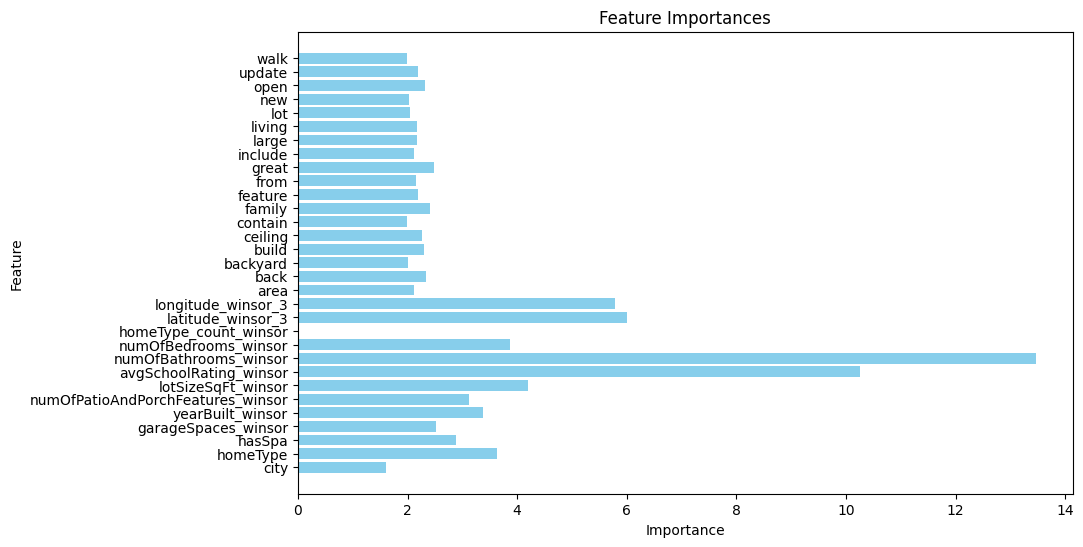

In [119]:
importances = modex_xgboost_best.feature_importances_

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances*100, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

In [120]:
feature_importance = pd.DataFrame({"features":feature_names, 
                                             "importances": importances*100})

feature_importance.sort_values(by='importances', ascending=False).head()

,features,importances
8,numOfBathrooms_winsor,13.467466
7,avgSchoolRating_winsor,10.251681
11,latitude_winsor_3,6.010605
12,longitude_winsor_3,5.778440
6,lotSizeSqFt_winsor,4.202297


In [121]:
feature_importance.describe().T

,count,mean,std,min,25%,50%,75%,max
importances,31.0,3.225806,2.605793,0.0,2.114195,2.296929,3.252571,13.467466


## FOR VALIDATION SET

In [122]:
preds_class = modex_xgboost_best.predict(X_validation)

In [123]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

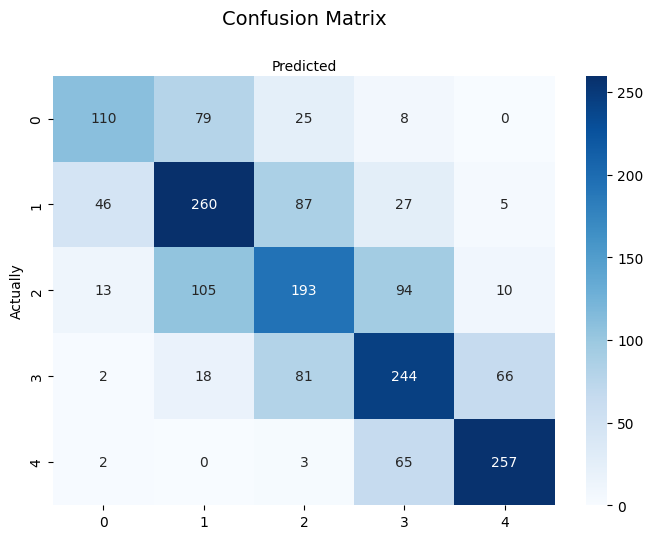

In [124]:
cm = pd.crosstab(y_validation, preds_class, rownames=['Actually'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(7,5))

sns.heatmap(pd.DataFrame(cm), annot=True, cmap="Blues" ,fmt='g',)
ax1.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion Matrix', y=1.1,fontsize=14)
plt.show()

In [125]:
acc=accuracy_score(y_validation,preds_class)
print('Accuracy =' , acc)

Accuracy = 0.5911111111111111


In [126]:
recall = recall_score(y_validation, preds_class, average='macro')
print('Recall =' ,recall)

Recall = 0.5903854259981964


In [127]:
precision = precision_score(y_validation, preds_class, average='macro')
print('Precision =' ,precision)

Precision = 0.6024370654170099


In [128]:
print("\nClassification Report:\n", classification_report(y_validation, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.46      0.58       222
           1       0.58      0.68      0.62       425
           2       0.51      0.49      0.50       415
           3       0.57      0.61      0.59       411
           4       0.78      0.77      0.77       327

    accuracy                           0.61      1800
   macro avg       0.64      0.60      0.61      1800
weighted avg       0.62      0.61      0.61      1800



## FOR TEST SET

In [129]:
y_test = transformed_test['priceRange']
X_test = transformed_test.drop(['priceRange'], axis=1)

In [130]:
preds_class_test = modex_xgboost_best.predict(X_test)

In [131]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

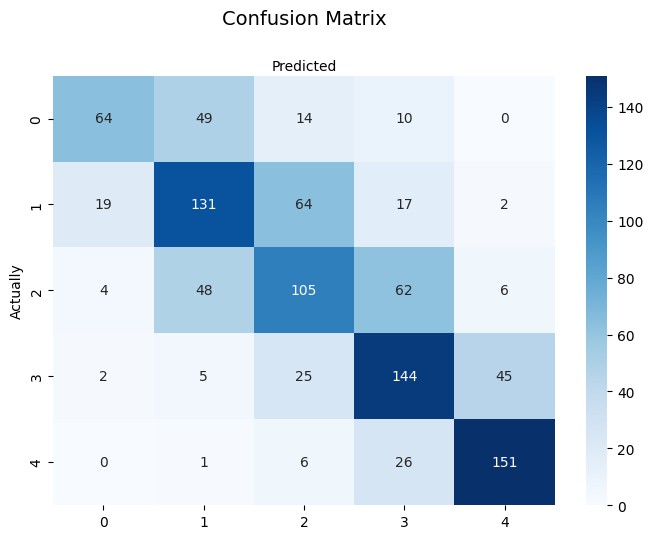

In [132]:
cm = pd.crosstab(y_test, preds_class_test, rownames=['Actually'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(7,5))

sns.heatmap(pd.DataFrame(cm), annot=True, cmap="Blues" ,fmt='g',)
ax1.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion Matrix', y=1.1,fontsize=14)
plt.show()

In [133]:
acc=accuracy_score(y_test,preds_class_test)
print('Accuracy =' , acc)

Accuracy = 0.595


In [134]:
recall = recall_score(y_test,preds_class_test, average='macro')
print('Recall =' ,recall)

Recall = 0.593657519063027


In [135]:
precision = precision_score(y_test,preds_class_test, average='macro')
print('Precision =' ,precision)

Precision = 0.6131530046895941


In [136]:
print("\nClassification Report:\n", classification_report(y_test,preds_class_test))


Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.47      0.57       137
           1       0.56      0.56      0.56       233
           2       0.49      0.47      0.48       225
           3       0.56      0.65      0.60       221
           4       0.74      0.82      0.78       184

    accuracy                           0.59      1000
   macro avg       0.61      0.59      0.60      1000
weighted avg       0.60      0.59      0.59      1000



# Verifying in the APP some data

In [147]:
raw_test[raw_test['city']!='austin'].loc[247]

uid                                                                        6236
city                                                            west lake hills
description                   TREMENDOUS OPPORTUNITY in Eanes ISD! Built by ...
homeType                                                          Single Family
latitude                                                              30.273518
longitude                                                            -97.822334
garageSpaces                                                                  3
hasSpa                                                                     True
yearBuilt                                                                  1998
numOfPatioAndPorchFeatures                                                    2
lotSizeSqFt                                                             14810.4
avgSchoolRating                                                             9.5
MedianStudentsPerTeacher                

In [148]:
raw_test[raw_test['city']!='austin']['description'].loc[247]

"TREMENDOUS OPPORTUNITY in Eanes ISD! Built by Brighton Homes in '98. Master on main with spacious bathroom and walk-in closet. There are 5 bedrooms and a flex space upstairs. An office, formal dining, 2 living areas, a powder bath, an open kitchen to a breakfast area great room, walk-in pantry and laundry room are also on the main. Pool, hottub and new cedar deck in fenced in backyard. The private location is close to shopping, schools, hiking, restaurants and one mile from Westlake HS. BEST BUY in 78746!"

In [151]:
raw_test.loc[953]

uid                                                                        2720
city                                                                     austin
description                   11417 Dona Villa Dr, Austin, TX 78726 is a sin...
homeType                                                          Single Family
latitude                                                              30.429384
longitude                                                            -97.836029
garageSpaces                                                                  0
hasSpa                                                                    False
yearBuilt                                                                  2006
numOfPatioAndPorchFeatures                                                    2
lotSizeSqFt                                                             13068.0
avgSchoolRating                                                             7.0
MedianStudentsPerTeacher                

In [150]:
raw_test['description'].loc[953]

'11417 Dona Villa Dr, Austin, TX 78726 is a single family home that contains 2,866 sq ft and was built in 2006. It contains 3 bedrooms and 3 bathrooms. \r\n \r\n'

In [154]:
raw_test.iloc[216]

uid                                                                        1893
city                                                                     austin
description                   Spectacular Renovation 60's Ranch. All stone e...
homeType                                                          Single Family
latitude                                                              30.380096
longitude                                                            -97.678513
garageSpaces                                                                  0
hasSpa                                                                    False
yearBuilt                                                                  1964
numOfPatioAndPorchFeatures                                                    0
lotSizeSqFt                                                             13068.0
avgSchoolRating                                                        3.333333
MedianStudentsPerTeacher                

In [156]:
raw_test['description'].loc[216]

"Spectacular Renovation 60's Ranch. All stone exterior on private lot with Old-Growth trees. Updates include Architectural Roof, paint inside & out, textured walls & ceilings, Designer lights, all solid surface flooring, flat trim & 5 Panel Doors.  Contemporary Baldwin Door Hardware.Fabulous Kitchen w/upgraded appliances, stone counters. Tiled Hotel style baths, Master w/ walk-in shower. Blown insulation walls & ceiling, double pane lowE windows. Double Entry Solid Mahogany Front Doors w/ Emtek Entry Handles. Beautiful n'hood just min from I-35, Mopac & The Domain."

In [61]:
# create the object of the model
xgb_classifier = XGBClassifier(reg_lambda=0.01,
                                        reg_alpha=0.1,
                                        n_estimators=300,
                                        max_depth=5,
                                        learning_rate=0.1,
                                        random_state=20230916)

In [62]:
# Fit model 
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
preds_class = model_xgb.predict(X_test[feat_names])

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Hyperparameter Tunning

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
RANDOM_SEED = 20230916

In [ ]:
# RandomForest
rf = RandomForestClassifier(random_state=RANDOM_SEED)
param_grid_forest = {
    "n_estimators": [100, 200, 300],
    "max_depth": [5, 10, 15],
    "criterion": ["gini", "entropy"],
    "max_leaf_nodes": [50, 100],
}

grid_forest = GridSearchCV(
    estimator=rf, param_grid=param_grid_forest, cv=5, n_jobs=-1, scoring="accuracy", verbose=0
)

model_forest = grid_forest.fit(X_train[list_features], y_train)

In [ ]:
best_params_forest = grid_forest.best_params_

In [ ]:
best_params_forest

In [ ]:
best_model = grid_forest.best_estimator_

In [ ]:
predictions_forest = best_model.predict(X_test[list_features])

In [ ]:
accuracy_forest = accuracy_score(y_test, predictions_forest)
print("Test accuracy:", accuracy_forest)

In [ ]:
print("\nClassification Report:\n", classification_report(y_test, predictions_forest))

## XGBClassifier

In [ ]:
# XGBoost Classifier
xgb_classifier = XGBClassifier(random_state=RANDOM_SEED)
param_grid_xgboost = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.1, 0.5],
    "max_depth": [5, 10],
    "reg_alpha": [0.01, 0.1],
    "reg_lambda": [0.01, 0.1],
}

grid_xgboost = GridSearchCV(
    estimator=xgb_classifier,
    param_grid=param_grid_xgboost,
    cv=5,
    n_jobs=-1,
    scoring="accuracy",
    verbose=0,
)
model_xgboost = grid_xgboost.fit(X_train[list_features], y_train)

In [ ]:
best_params_xgboost = grid_xgboost.best_params_

In [ ]:
best_model_xgboost = grid_xgboost.best_estimator_

In [ ]:
best_params_xgboost

In [ ]:
predictions_xgboost = best_model_xgboost.predict(X_test[list_features])

In [ ]:
accuracy_xgboost = accuracy_score(y_test, predictions_xgboost)
print("Test accuracy:", accuracy_xgboost)

In [ ]:
print("Accuracy:", accuracy_score(y_test, predictions_xgboost))
print("\nClassification Report:\n", classification_report(y_test, predictions_xgboost))

## Comparing both models

In [ ]:
random_forest_classifier = cv_score(RandomForestClassifier(criterion='entropy',
                                                           max_depth= 15,
                                                           max_leaf_nodes= 100,
                                                           n_estimators= 200,
                                                           random_state=20230916), 
                                    df = X_train, df_y = y_train)

In [251]:
xgb_classifier = cv_score(XGBClassifier(reg_lambda=0.01,
                                        reg_alpha=0.1,
                                        n_estimators=300,
                                        max_depth=5,
                                        learning_rate=0.1,
                                        random_state=20230916), 
                          df = X_train[features], df_y = y_train)

The duration for training the model is: 0.7300071716308594


In [252]:
results_df = pd.DataFrame({'RandomForestClassifier':random_forest_classifier, 
                           'XGBClassifier': xgb_classifier})

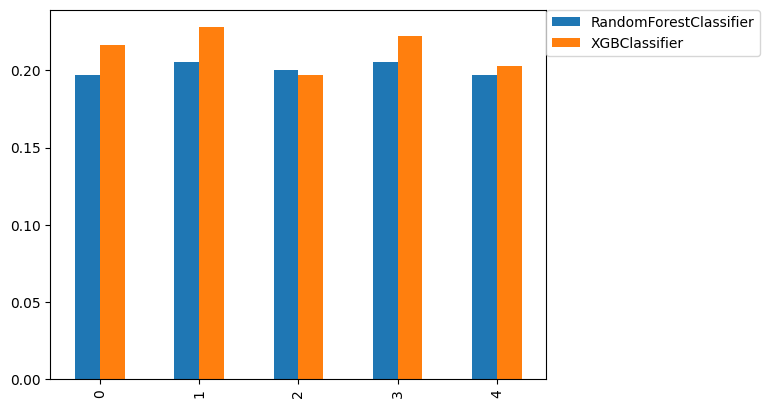

In [253]:
results_df.plot(y=["RandomForestClassifier", 'XGBClassifier'], kind="bar", legend=False)
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
plt.show()

## Stacking both models

In [84]:
# Base models
estimators = [
    ('rf', RandomForestClassifier(criterion='entropy',
                                  max_depth= 15,
                                  max_leaf_nodes= 100,
                                  n_estimators= 200,
                                  random_state=20230916)),
    ('xgb', XGBClassifier(learning_rate= 0.1,
                                  max_depth= 10,
                                  n_estimators= 300,
                                  reg_alpha= 0.01,
                                  reg_lambda= 0.1, 
                                  random_state=20230916)),
]

# Meta-model
meta_model = LogisticRegression()

# Stacking classifier
stacking_clf = StackingClassifier(estimators=estimators, 
                                  final_estimator=meta_model,
                                  cv=5)

# Fit the model
stacking_clf.fit(X_train, y_train)

# Make predictions
y_pred = stacking_clf.predict(X_test)

In [85]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6172222222222222

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.50      0.60       222
           1       0.60      0.68      0.64       425
           2       0.53      0.49      0.51       415
           3       0.57      0.61      0.59       411
           4       0.76      0.79      0.77       327

    accuracy                           0.62      1800
   macro avg       0.64      0.61      0.62      1800
weighted avg       0.62      0.62      0.62      1800

